# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ *liste des points auxquels on cherche à répondre*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

### convert categoricals = False puts the variable value in the df instead of the label (ex. binary output instead of 'yes/no')

In [3]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
#education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
education = ['UENG','UENGNEG','UENGPOS']
#family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family = ['GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']

In [4]:
# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if x == np.inf else x)

In [5]:
# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]


In [6]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')
# replace all the missing values by the str 'no data', No by 0 and Yes by 1
child.replace([-7,-8,-9],-1,inplace=True) 

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,KAPPMED,SSHELP,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS
0,5561612801,1,5561612803,5561612800,F,3,15,WI,2,A1,...,-1,-1,2,0,3,1,4,1,0.75,-1
1,5470400001,2,5470400003,5470400000,M,14,15,WI,2,A1,...,1,-1,0,2,3,2,2,2,1.50,-1
2,5787427204,2,5787427205,5787427200,F,9,15,WI,2,A1,...,-1,-1,0,4,6,1,3,2,2.00,2
3,5410681601,1,5410681604,5410681600,M,4,15,WI,2,A1,...,-1,-1,3,0,5,1,2,2,2.50,2
4,5051721601,2,5051721605,5051721600,F,17,15,WI,2,A1,...,-1,-1,0,4,5,1,4,2,1.25,1


In [7]:
# Divide child data in three dfs

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal child, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [8]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 53)
fc2: (10925, 53)
fc3:(11087, 53)
True


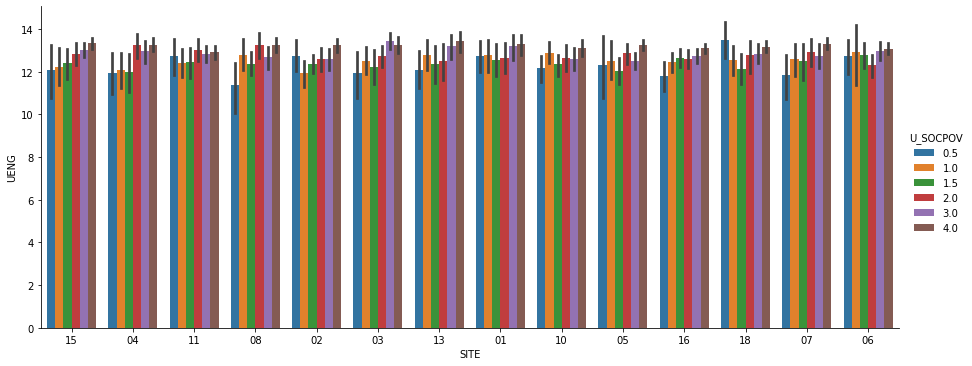

In [9]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc2, height=5, aspect=2.5)

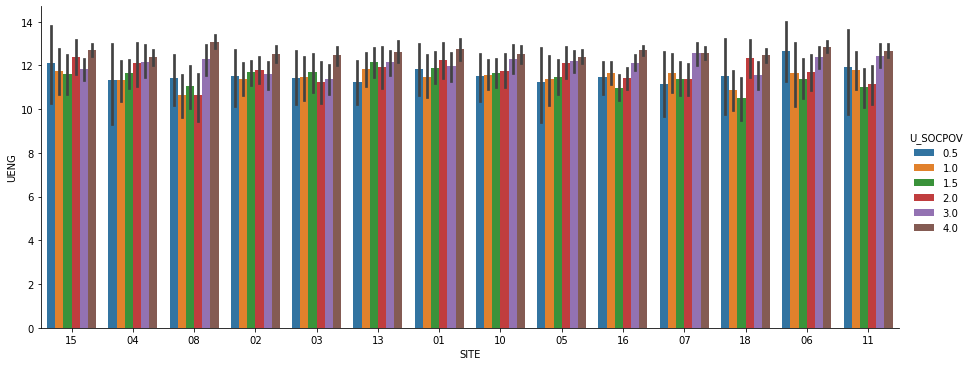

In [10]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc3, height=5, aspect=2.5)

## Propensity score attempt

In [11]:
# returns a regression of the predictors on the outcome, using only subects that answered to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
        
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    return smf.ols(formula=model, data=df.loc[(df[outcome] != -1) & (bools)]).fit()

In [12]:
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        return df.loc[(df[outcome] != -1) & (df[predictors[0]] != -1)]
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    return df.loc[(df[outcome] != -1) & (bools)]

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

outcome = 'UENG'
predictors = ['UFAMSTR','UMH2','OVERCROWDING']
df_noNull = df_NN(child,outcome,predictors)
glm = sm.GLM(df_noNull[outcome].values, df_noNull[predictors].replace(2,0).values)
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                21291
Model:                            GLM   Df Residuals:                    21288
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          9.4434
Method:                          IRLS   Log-Likelihood:                -54112.
Date:                Thu, 03 Dec 2020   Deviance:                   2.0103e+05
Time:                        12:02:39   Pearson chi2:                 2.01e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2114      0.012     17.486      0.000       0.188       0.235
x2             0.1404      0.001    222.607      0.000       0.139       0.142
x3             0.6492      0.030     21.318      0.000       0.590       0.709
==============================================================================
"""

In [14]:
res.predict(df_noNull[predictors].replace(2,0).values)

array([11.50600158, 14.67724115,  6.9903933 , ..., 15.32644575,
       12.56699766, 11.48730734])

In [15]:
deltas = res.predict(df_noNull[predictors].replace(2,0).values) - df_noNull[outcome].values
print(deltas.mean(),deltas.std())
# mauvaises predictions -> GLM meh

-0.24442685907632183 3.0630629053899923


In [16]:
reg = RandomForestRegressor()
X = df_noNull[predictors].replace(2,0).values.reshape(1,-1)
y = df_noNull[outcome].values.reshape(1,-1)
reg.fit(X, y)
reg.predict(X)-y #=array(0) si le RFR a marché

array([[0., 0., 0., ..., 0., 0., 0.]])

In [17]:
#sns.pairplot(child[income+programs+income_hh+housing_hh+programs_hh+education])

In [18]:
#sns.pairplot(child[income+income_hh+housing_hh+education])

In [19]:
#sns.pairplot(child[housing_hh+education])

## Education

In [20]:
outcome = 'UENG'
predictors = family+income+housing_hh
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     9.584
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           6.82e-13
Time:                        12:02:40   Log-Likelihood:                -2577.3
No. Observations:                1099   AIC:                             5173.
Df Residuals:                    1090   BIC:                             5218.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.2790      0.765     13.443   

In [21]:
# Keep only significant variables
outcome = 'UENG'
predictors = ['UFAMSTR','UMH2','MNBEDRMS','OVERCROWDING']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     136.2
Date:                Thu, 03 Dec 2020   Prob (F-statistic):          1.15e-113
Time:                        12:02:40   Log-Likelihood:                -24266.
No. Observations:               10543   AIC:                         4.854e+04
Df Residuals:                   10538   BIC:                         4.858e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.2903      0.196     52.428   

## Health

In [22]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     14.92
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           6.82e-21
Time:                        12:02:40   Log-Likelihood:                -1386.5
No. Observations:                1104   AIC:                             2791.
Df Residuals:                    1095   BIC:                             2836.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0843      0.257     11.995   

In [23]:
# Significant variables
outcome = 'BHLTHN'
predictors = ['UFAMSTR','UMH2','U_SOCPOV','OVERCROWDING']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     255.0
Date:                Thu, 03 Dec 2020   Prob (F-statistic):          1.46e-209
Time:                        12:02:40   Log-Likelihood:                -13373.
No. Observations:               10671   AIC:                         2.676e+04
Df Residuals:                   10666   BIC:                         2.679e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8799      0.059     48.814   

## Mental health


**fc2**


In [24]:
outcome = 'UBPIA'
predictors = family+income+housing_hh
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     20.48
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           4.40e-29
Time:                        12:02:40   Log-Likelihood:                -2358.7
No. Observations:                1102   AIC:                             4735.
Df Residuals:                    1093   BIC:                             4780.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.9397      0.623     17.566   

In [25]:
# Significant variables
outcome = 'UBPIA'
predictors = ['UFAMSTR','UMH2','MNBEDRMS','MOWNRENT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     395.6
Date:                Thu, 03 Dec 2020   Prob (F-statistic):          3.30e-318
Time:                        12:02:40   Log-Likelihood:                -22102.
No. Observations:               10620   AIC:                         4.421e+04
Df Residuals:                   10615   BIC:                         4.425e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2237      0.163     69.008      0.0

In [26]:
# Significant variables
outcome = 'UBPIA'
predictors = ['UFAMSTR','UMH2']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     792.0
Date:                Thu, 03 Dec 2020   Prob (F-statistic):          2.37e-321
Time:                        12:02:40   Log-Likelihood:                -22131.
No. Observations:               10635   AIC:                         4.427e+04
Df Residuals:                   10632   BIC:                         4.429e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1466      0.123     90.886      0.0

**fc3**

In [27]:
outcome = 'UBPIB'
predictors = family+income+housing_hh
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     13.13
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           9.94e-18
Time:                        12:02:40   Log-Likelihood:                -1477.5
No. Observations:                 700   AIC:                             2973.
Df Residuals:                     691   BIC:                             3014.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.5808      0.746     15.516   

In [28]:
# Significant
outcome = 'UBPIB'
predictors = ['UFAMSTR','UMH2']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     894.6
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:02:40   Log-Likelihood:                -23233.
No. Observations:               10849   AIC:                         4.647e+04
Df Residuals:                   10846   BIC:                         4.649e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6345      0.123     86.271      0.0

In [29]:
df_noNull = df_NN(fc3,outcome, predictors)
xtest = df_noNull[['UFAMSTR','UMH2']]
diff = (res.predict(xtest) - df_noNull['UBPIB'])
print(diff.mean(),diff.std())
#error is normally distributed -> good, but the low r squared gives a rather high std

-3.011695214147548e-13 2.059697525814326


## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Mental health of UMH2

In [30]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     234.1
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:02:40   Log-Likelihood:            -1.3349e+05
No. Observations:               33553   AIC:                         2.670e+05
Df Residuals:                   33545   BIC:                         2.671e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       72.4220      0.611    118.487   

In [31]:
# Significant
outcome = 'UMH2'
predictors = ['CHLD0_5','CHLD6_17','U_SOCPOV','MNBEDRMS','MOWNRENT']
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     328.3
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:02:41   Log-Likelihood:            -1.3367e+05
No. Observations:               33598   AIC:                         2.673e+05
Df Residuals:                   33592   BIC:                         2.674e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.9315      0.460    158.662      0.0

In [32]:
# Significant
outcome = 'UMH2'
predictors = ['CHLD0_5','U_SOCPOV','MNBEDRMS','MOWNRENT']
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     410.3
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:02:41   Log-Likelihood:            -1.3367e+05
No. Observations:               33598   AIC:                         2.673e+05
Df Residuals:                   33593   BIC:                         2.674e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.8818      0.449    162.442      0.0

In [33]:
outcome = 'UENGNEG'
predictors = ['UFAMSTR']
df_noNull = df_NN(fc23,outcome, predictors)

<AxesSubplot:xlabel='UFAMSTR', ylabel='Probability'>

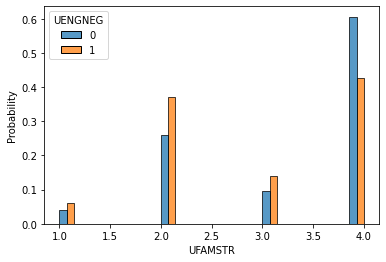

In [34]:
sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_noNull, common_norm=False, multiple='dodge')
# dans quelles familles sont distribués les gars mauvais